# Pretraining on MNIST
The objective is to pretrain a basic MLP (Multi-Layer Perceptron) in order to create the base corrupted model to later on capture photos from finetuning.

First, all the libraries will be imported:

In [151]:
import os
import sys
from tqdm import tqdm
from IPython.display import clear_output



import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from safetensors.torch import save_file
import random
import numpy as np


# To add src to the path so that we can import modules
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
if not parent_directory.endswith("dataset_stealing_with_privacy_doors"):
    sys.path.append(os.path.join(current_directory, 'dataset_stealing_with_privacy_doors'))
else:
    sys.path.append(parent_directory)

try:
    from src import DATA_DIR, MODELS_DIR
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

These are the parameters used for pretraining and seed init:

In [152]:
params = {
    'batch_size':64, 
    'eval_batch_size':64,
    'hidden_size': 512,
    'num_epochs':10,
    'num_classes':10,
    'learning_rate':1e-4,
    'log_interval':300,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 33
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

The MNIST dataset is downloaded using the torchvision.datasets module. The dataset is then loaded into a DataLoader object, which is used to iterate over the dataset in batches. The Normalization performed is between 0-1, in order to be able to effectively activate the latches for specific datapoints. 

In [153]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=params['batch_size'], shuffle=True)
val_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=params['eval_batch_size'], shuffle=False)
print("Number of images in train:",len(train_dataset))
print("Number of images in validation:",len(val_dataset))
print("Splits:", "{:.2f}".format(len(train_loader) / (len(val_loader)+len(train_loader))),
      "/","{:.2f}".format(len(val_loader) / (len(val_loader)+len(train_loader))))

Number of images in train: 60000
Number of images in validation: 10000
Splits: 0.86 / 0.14


In [154]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = train_dataset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} grayscale images ({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width pixels)')
print(f'In the case of the labels, we obtain {blabel.shape[0]} batched integers, one per image')

Img shape:  torch.Size([1, 28, 28])
Label:  5
Batch Img shape:  torch.Size([64, 1, 28, 28])
Batch Label shape:  torch.Size([64])
The Batched tensors return a collection of 64 grayscale images (1 channel, 28 height pixels, 28 width pixels)
In the case of the labels, we obtain 64 batched integers, one per image


(-0.5, 241.5, 241.5, -0.5)

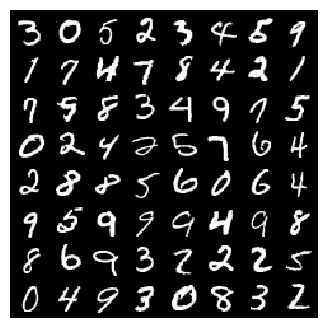

In [155]:
# make_grid is a function from the torchvision package that transforms a batch
# of images to a grid of images
img_grid = make_grid(bimg)

plt.figure(figsize = (4, 4))
plt.imshow(img_grid.permute(1, 2, 0), interpolation='nearest')
plt.axis('off')

## Model training
Now the basic MLP is defined, with 3 layers. Keeping in mind that there are 10 classes (10 digits) and the input size is about 28*28 pixels. The image is flattened on the first input, and the decided activation function is ReLu.

In [156]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.fc1(x)) # layer 2
        x = self.fc2(x) # layer 3
        return x

In [157]:
# Initialize the model, loss function and optimizer
model = MLP(params['hidden_size'], params['num_classes']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [158]:
def train (epoch_id, model, train_loader, device):
    model.train()
    global_epoch_loss = 0.0
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader),
                                                    desc = f'(TRAIN)Epoch {epoch_id+1}', 
                                                    miniters=int(len(train_loader)/params['log_interval'])):
        # Forward and backward pass
        optimizer.zero_grad()
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Store results
        global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
        all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
        all_labels = torch.cat((all_labels, labels.cpu()))
        
        # Show the batch results every 100 batches
        if i % params['log_interval'] == 0: # Print the metrics every 100 batches
            predicted_label = torch.argmax(outputs, dim=1)
            acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
            tqdm.write(f"TRAIN [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")
    
    acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(train_loader.dataset)*100
    return model, global_epoch_loss/len(train_loader.dataset), acc_epoch

def validation (epoch_id, model,val_loader, device):
    model.eval()
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    global_epoch_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader),
                                                    desc = f'(VAL)Epoch {epoch_id+1}', 
                                                    miniters=int(len(val_loader)/params['log_interval'])):
            # Forward pass
            images = images.to(device); labels = labels.to(device)
            outputs = model(images)
            predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
            loss = criterion(outputs, labels)
            # Store results
            all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
            all_labels = torch.cat((all_labels, labels.cpu()))
            global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
            
            # Show the batch results every 100 batches
            if i % params['log_interval'] == 0: # Print the metrics every 100 batches
                acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
                tqdm.write(f"VAL [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")

        acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(val_loader.dataset)*100
    return global_epoch_loss/len(val_loader.dataset), acc_epoch

In [159]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch_id in range(params['num_epochs']):
    tqdm.write(f"EPOCH {epoch_id+1} ------------------------------------")
    model, train_loss, train_acc = train(epoch_id, model, train_loader, device)
    clear_output(wait=True)
    print(f"Epoch {epoch_id+1} mean training loss: {train_loss:.4f}")
    print(f"Epoch {epoch_id+1} total training accuracy: {train_acc:.2f}%")
    val_loss, val_acc = validation(epoch_id, model,val_loader, device)
    print(f"Epoch {epoch_id+1} mean validation loss: {val_loss:.4f}")
    print(f"Epoch {epoch_id+1} total validation accuracy: {val_acc:.2f}%")
    
    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 10 mean training loss: 0.6038
Epoch 10 total training accuracy: 86.04%


(VAL)Epoch 10:  16%|█▌        | 25/157 [00:00<00:00, 243.83it/s]

VAL [1/938], Batch accuracy: 89.062%; Batch Loss: 0.590


(VAL)Epoch 10: 100%|██████████| 157/157 [00:00<00:00, 262.61it/s]

Epoch 10 mean validation loss: 0.5620
Epoch 10 total validation accuracy: 87.05%


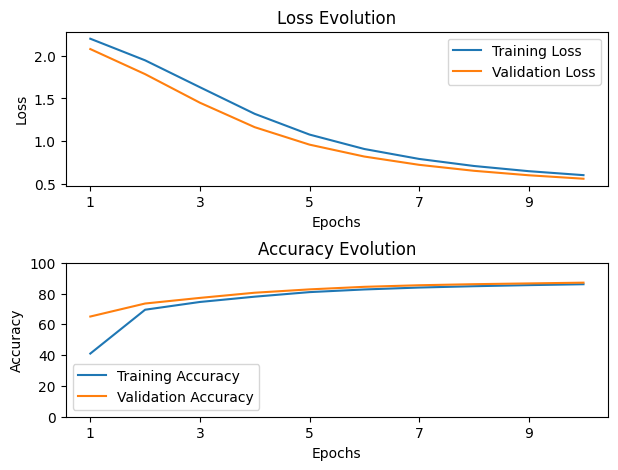

In [160]:
# Graficar la evolución de la pérdida y la precisión
plt.figure(figsize=(7, 5))

plt.subplot(2, 1, 1)
plt.plot(range(1, params['num_epochs'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, params['num_epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x


plt.subplot(2, 1, 2)
plt.plot(range(1, params['num_epochs'] + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, params['num_epochs'] + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.ylim(0, 100)  # Establecer los límites del eje y entre 0 y 100%
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

plt.subplots_adjust(hspace=0.5)

plt.show()

Save results using safetensors

In [161]:
archive_name = "model_pretrained.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(model.state_dict(), saving_path)

## Validation of results
First a batch of validation images will be created to make inference. Then the resulting outputs will be compared later with the corrupted model. 

In [162]:
# Get a batch of validation data
val_iter = iter(val_loader)
val_images, val_labels = next(val_iter)
val_images = val_images.to(device); val_labels = val_labels.to(device)

Now the pretrained model will be evaluated. 

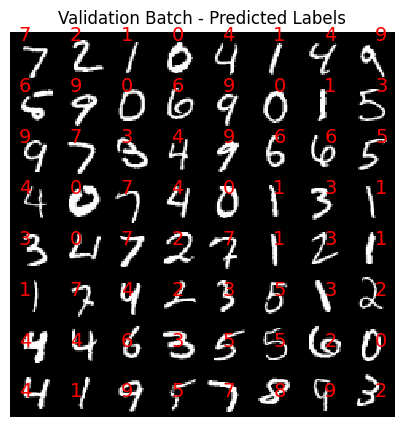

In [163]:
# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(val_images)
    softmax_outputs = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot the grid with predicted labels
plt.figure(figsize=(5, 5))
plt.imshow(val_img_grid.cpu().permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.title('Validation Batch - Predicted Labels')

# Annotate the images with predicted labels
for i in range(val_images.size(0)):
    plt.text(i % 8 * 32 + 5, i // 8 * 32 + 5, str(predicted[i].item()), color='red', fontsize=14)

plt.show()

It can be seen how the model works correctly. 

## Model corruption
Now the model will be corrupted. It is set a new weight between the last classifier layer (FC3) and the second layer(FC2). It is basically an identity vector that multiplies with the output of FC2 and set as input of FC3. All elements of this vector are one, except some random positions that will be set to big constants for capturing the images during finetuning. First this vector is created:

In [164]:
features = 512
corrupted_neurons = 64

constant_vector = torch.ones(features)
positions = random.sample(range(features), corrupted_neurons)
# Create random numbers for corrupted neurons between 1000 and 10000 using PyTorch
random_constant = 1000000
constant_vector[positions] = constant_vector[positions] * 1000
# Count how many are greater than 1
count_greater_than_one = torch.sum(constant_vector > 1).item()
print(f"Number of elements greater than 1: {count_greater_than_one}")
print(f"Size of constant vector: {constant_vector.size()}")

Number of elements greater than 1: 64
Size of constant vector: torch.Size([512])


We sample the new weights in a unit sphere. 

In [165]:
def sample_weights_on_sphere(dim, num_samples):
    # Generate random points from a normal distribution
    random_points = torch.randn(num_samples, dim)
    # Normalize each point to lie on the surface of a sphere
    sphere_points = random_points / random_points.norm(dim=1, keepdim=True)
    return sphere_points

def sample_bias(num_samples, shift_value):
    # Generate random points from a normal distribution
    biases = torch.randn(num_samples) + shift_value
    return biases

weights_corrupted = sample_weights_on_sphere(28*28, features)
biases_corrupted = sample_bias(features, -5)

print(f"Size of weights: {weights_corrupted.size()}")
print(f"Size of biases: {biases_corrupted.size()}")

Size of weights: torch.Size([512, 784])
Size of biases: torch.Size([512])


Later, we modify the MLP class. We will call the new MLP as "advanced", a fine way to tell that the model is modified from the standard MLP (this could be hidden in a real use scenario). The modification is explained above. 

In [166]:
# Define the MLP model
class MLP_advanced(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP_advanced, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.constant = nn.Parameter(torch.ones(hidden_size))

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.fc1(x)) # layer 2
        x = torch.relu(x*self.constant)# Corrupted layer
        x = self.fc2(x) # layer 3
        return x

Now the weights from the pretrained model are fusioned with the modified constants. Only the decided random neurons will be affected. It can be seen how this "identity" layer is not seen from printing the model.

In [167]:
# Initialize the modified model
corrupted_model = MLP_advanced(params['hidden_size'], params['num_classes'])

# Load the pre-trained weights into the modified model
corrupted_model.fc1.load_state_dict(model.fc1.state_dict())
corrupted_model.fc2.load_state_dict(model.fc2.state_dict())

# Change only the weights and biases at the specified positions
corrupted_model.fc1.weight.data[positions] = weights_corrupted[positions]
corrupted_model.fc1.bias.data[positions] = biases_corrupted[positions]
corrupted_model.constant.data = constant_vector
print(corrupted_model)


MLP_advanced(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


But, in the corrupted model is included:

In [168]:
# Print the weights of the advanced layer (constant_vector)
for name, param in corrupted_model.named_parameters():
    if name == "constant" and param.requires_grad:
        print(f"Layer: {name} | Size: {param.size()} | Values [0-10] : {param[:10]}")  # Print first value for brevity

Layer: constant | Size: torch.Size([512]) | Values [0-10] : tensor([   1.,    1.,    1., 1000.,    1.,    1., 1000.,    1.,    1., 1000.],
       grad_fn=<SliceBackward0>)


Now this modified version will be put into test with the created batch of validation images. 

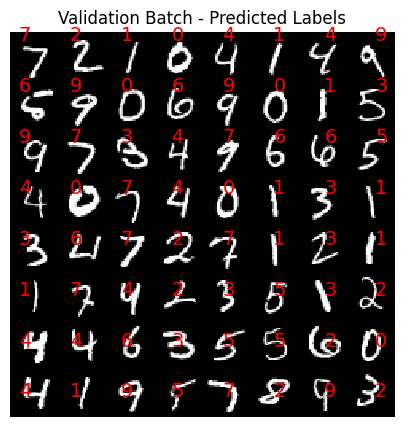

In [169]:
# Set the model to evaluation mode
corrupted_model.to(device)
corrupted_model.eval()

# Make predictions
with torch.no_grad():
    outputs_corrupted = corrupted_model(val_images)
    softmax_outputs_corrupted = F.softmax(outputs_corrupted, dim=1)
    _, predicted = torch.max(outputs_corrupted.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot the grid with predicted labels
plt.figure(figsize=(5, 5))
plt.imshow(val_img_grid.cpu().permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.title('Validation Batch - Predicted Labels')

# Annotate the images with predicted labels
for i in range(val_images.size(0)):
    plt.text(i % 8 * 32 + 5, i // 8 * 32 + 5, str(predicted[i].item()), color='red', fontsize=14)

plt.show()

The results between multiplying the constant and not, are very similar. It can be compared how the outputs and softmax differ, but the predicted label not. 

In [170]:
# Print logit outputs for both corrupted and non-corrupted models
print("Model's outputs:")
print("Non-corrupted:", outputs[0,:].cpu().numpy())
print("Corrupted:", outputs_corrupted[0,:].cpu().numpy())

# Print softmax outputs for both corrupted and non-corrupted models
print("\nSoftmax outputs:")
print("Non-corrupted:", softmax_outputs[0,:].cpu().numpy())
print("Corrupted:", softmax_outputs_corrupted[0,:].cpu().numpy())

# Print prediction
print("\nPredicted label:")
print("Non-corrupted:", softmax_outputs[0,:].argmax().item())
print("Corrupted:", softmax_outputs_corrupted[0,:].argmax().item())

Model's outputs:
Non-corrupted: [-0.17994809 -2.7550042  -0.8665521   0.03495882  0.38376176 -0.26647568
 -2.470395    5.468429   -0.4360631   2.2201862 ]
Corrupted: [-0.01636203 -2.5024018  -0.48545843 -0.10299959  0.35573307 -0.35530365
 -2.0677686   4.904967   -0.48878294  1.9299564 ]

Softmax outputs:
Non-corrupted: [3.3197890e-03 2.5280044e-04 1.6707919e-03 4.1156979e-03 5.8334670e-03
 3.0446134e-03 3.3603309e-04 9.4225752e-01 2.5696924e-03 3.6599543e-02]
Corrupted: [6.6787400e-03 5.5593142e-04 4.1780025e-03 6.1244676e-03 9.6893217e-03
 4.7587631e-03 8.5857860e-04 9.1622168e-01 4.1641355e-03 4.6770282e-02]

Predicted label:
Non-corrupted: 7
Corrupted: 7


Finally the corrupted model will be saved using safetensors, also the positions of the corrupted neurons.

In [172]:
archive_name = "model_pretrained_advanced.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(corrupted_model.state_dict(), saving_path)
archive_name = "corrupted_positions.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
# Convert positions to a dictionary
positions_dict = {"positions": torch.Tensor(positions)}
save_file(positions_dict, saving_path)